# Future weather models 

Create synthetic future weather data up to 2100 by using climate projections by DWD: 

https://www.dwd.de/DE/klimaumwelt/klimaatlas/klimaatlas_node.html;jsessionid=D84E870D1392681BE23498BDEFDD6364.live11043

1. Baseline model: no change relative to 1971-2000 average
2. Reserved model: slight changes
3. T-model: only T-changes, pronounced
4. P-model: only P-changes, pronounced
5. Mid model: Intermediate changes in P and T
6. Worst-case model: Extreme changes in P and T

Always calculate anomalies relative to baseline model.

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

pd.set_option('display.max_rows', 100)


## Load data

In [3]:
w = pd.read_csv('./data/weather_collections/weather_daily_region.csv')

# change date column to datetime type
w.date = pd.to_datetime(w.date)

# restrict data to the reference period 1971-2000
w = w.loc[w['date'] >= pd.to_datetime('1971-01-01')]
w = w.loc[w['date'] <= pd.to_datetime('2000-12-31')]

# set datetime index
w.set_index('date', inplace=True)
#w['date'] = w.index
w

,station_id_count,precip_mean,precip_min,precip_max,precip_std,tmean_mean,tmean_min,tmean_max,tmean_std,tmax_mean,...,tmax_max,tmax_std,tmin_mean,tmin_min,tmin_max,tmin_std,moisture_mean,moisture_min,moisture_max,moisture_std
date,,,,,,,,,,,,,,,,,,,,,
1971-01-01,7,0.028571,0.0,0.2,0.075593,-11.385714,-13.5,-10.2,1.175342,-6.228571,...,-4.4,1.443046,-14.471429,-17.5,-12.7,1.715337,83.000000,80.0,87.0,3.162278
1971-01-02,7,0.400000,0.0,1.0,0.424264,-8.042857,-9.3,-7.4,0.723089,-6.257143,...,-5.5,0.475595,-14.828571,-17.5,-12.1,1.829129,82.333333,79.0,88.0,3.076795
1971-01-03,7,0.757143,0.2,2.0,0.618755,-5.857143,-6.5,-4.7,0.699660,-4.628571,...,-2.7,1.338798,-8.242857,-10.1,-7.3,1.008063,86.500000,84.0,93.0,3.271085
1971-01-04,7,0.128571,0.0,0.5,0.179947,-5.414286,-6.2,-4.7,0.636209,-4.057143,...,-2.5,0.832380,-6.171429,-7.3,-5.2,0.809762,88.000000,84.0,94.0,3.794733
1971-01-05,7,0.000000,0.0,0.0,0.000000,-9.100000,-12.7,-7.3,1.940790,-5.414286,...,-4.0,0.971989,-11.357143,-15.0,-8.6,2.428894,87.666667,85.0,91.0,2.658320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-27,5,1.320000,0.0,1.9,0.828855,4.520000,4.0,5.2,0.540370,6.820000,...,8.2,0.861394,1.360000,0.2,2.6,1.080740,95.000000,93.0,98.0,2.000000
2000-12-28,5,0.060000,0.0,0.2,0.089443,3.100000,0.0,4.3,1.752142,5.920000,...,6.8,0.653452,1.260000,-1.5,2.7,1.697940,78.200000,71.0,90.0,7.596052
2000-12-29,5,4.280000,3.0,6.5,1.347961,0.160000,-1.4,1.0,0.928978,2.560000,...,3.9,1.663731,-1.060000,-2.1,0.0,0.756968,95.200000,92.0,97.0,1.923538


<Axes: xlabel='date', ylabel='tmean_mean'>

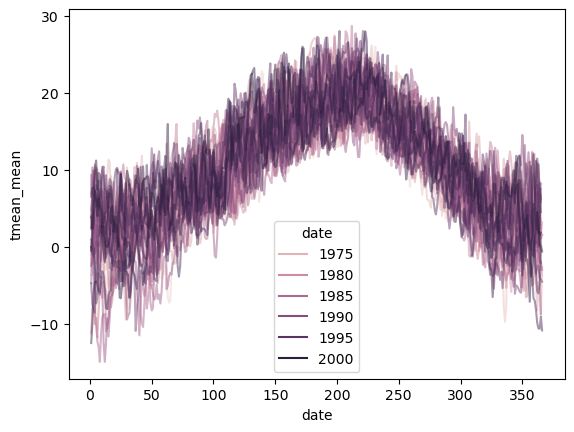

In [4]:
sns.lineplot(data=w, x=w.index.dayofyear, y='tmean_mean',
             hue=w.index.year,
             alpha=0.5)
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))
#plt.xlim(0,365)

## Create reference year

First iteration only with average values. Later try more elaborate calculations.

In [5]:
ref_year = w.groupby(by=[w.index.month.rename('month'),
                         w.index.day.rename('day')]
                    ).agg({'precip_mean': 'mean',
                          'moisture_mean': 'mean',
                          'tmean_mean': 'mean',
                          'precip_std': 'std',
                          'moisture_std': 'std',
                          'tmean_std': 'std',})

ref_year.reset_index(inplace=True)

In [6]:
ref_year['month'] = ref_year['month'].astype(str).str.zfill(2)
ref_year['day'] = ref_year['day'].astype(str).str.zfill(2)
ref_year['month_day'] = ref_year['month'] + '-' + ref_year['day']

In [7]:
ref_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          366 non-null    object 
 1   day            366 non-null    object 
 2   precip_mean    366 non-null    float64
 3   moisture_mean  366 non-null    float64
 4   tmean_mean     366 non-null    float64
 5   precip_std     366 non-null    float64
 6   moisture_std   366 non-null    float64
 7   tmean_std      366 non-null    float64
 8   month_day      366 non-null    object 
dtypes: float64(6), object(3)
memory usage: 25.9+ KB


In [8]:
ref_year['precip_mean']

0      1.648532
1      1.958282
2      2.445984
3      1.865794
4      2.433579
         ...   
361    1.820417
362    1.316032
363    2.222389
364    2.716758
365    2.006563
Name: precip_mean, Length: 366, dtype: float64

In [9]:
ref_year['precip_std'].quantile(0.05)#.median()

0.8689413662434877

## Create test synthetic weather time series

Leap years are a problem. The below code generates the proper dates for the specified time period, including leap years. To create synthetic data:

1. create date column
2. create month-day column
3. join with artificial data table on the month-day column

In [10]:
year_df = create_year_df(2025)

year_df.head()

,date,month_day
2025-01-01,2025-01-01,01-01
2025-01-02,2025-01-02,01-02
2025-01-03,2025-01-03,01-03
2025-01-04,2025-01-04,01-04
2025-01-05,2025-01-05,01-05


In [11]:
synth = merge_weather_dates(ref_year, year_df)

synth.head()

,date,precip_mean,moisture_mean,tmean_mean,precip_std,moisture_std,tmean_std
date,,,,,,,
2025-01-01,2025-01-01,1.648532,84.921627,0.440623,1.122057,1.814339,0.349213
2025-01-02,2025-01-02,1.958282,86.353730,1.405563,1.543725,1.748377,0.466580
2025-01-03,2025-01-03,2.445984,82.955595,1.789440,1.221580,1.836179,0.386965
2025-01-04,2025-01-04,1.865794,83.210635,1.421913,2.122723,1.974659,0.466672
2025-01-05,2025-01-05,2.433579,82.913690,1.622044,1.430935,2.911046,0.497324


<Axes: xlabel='date', ylabel='tmean_mean'>

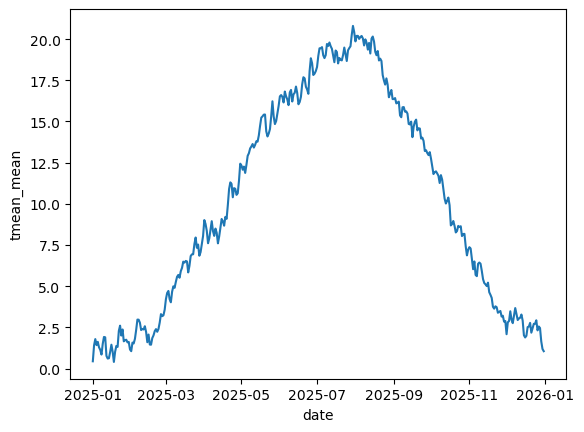

In [12]:
sns.lineplot(data=synth, x='date', y='tmean_mean')

In [13]:
print(synth['precip_mean'].sum(), synth['tmean_mean'].mean())

694.671369047619 10.100078473581213


In [14]:
synth['precip_std'].max()#/365

7.577288130360688

In [15]:
if False:
    synth.to_csv('./data/weather_future/ref_year.csv', index=False)

In [16]:
synth = calc_cumulative_weather(synth)
synth

,date,precip_mean,moisture_mean,tmean_mean,precip_std,moisture_std,tmean_std,precip_mean_prev_2d_sum,tmean_mean_prev_2d_mean,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,
2025-01-01,2025-01-01,1.648532,84.921627,0.440623,1.122057,1.814339,0.349213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02,2025-01-02,1.958282,86.353730,1.405563,1.543725,1.748377,0.466580,3.606813,0.923093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-03,2025-01-03,2.445984,82.955595,1.789440,1.221580,1.836179,0.386965,4.404266,1.597502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-04,2025-01-04,1.865794,83.210635,1.421913,2.122723,1.974659,0.466672,4.311778,1.605677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-05,2025-01-05,2.433579,82.913690,1.622044,1.430935,2.911046,0.497324,4.299373,1.521978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-27,2025-12-27,1.820417,83.405556,2.552004,1.444886,1.511458,0.448116,3.470706,2.434857,12.510643,2.550647,66.920980,2.765211,188.070087,6.122185,NaN,NaN,NaN,NaN
2025-12-28,2025-12-28,1.316032,83.336786,2.461000,0.934792,1.952753,0.443350,3.136448,2.506502,12.119468,2.591158,66.052512,2.740415,188.254813,6.005547,NaN,NaN,NaN,NaN
2025-12-29,2025-12-29,2.222389,84.247024,1.648060,1.809798,2.530036,0.461310,3.538421,2.054530,12.709587,2.477906,66.068020,2.700499,188.307409,5.877864,NaN,NaN,NaN,NaN


## Create reference scenario

In [17]:
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 0#2/100 # °C absolute change per year
y2y_p_change = 0#0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [18]:
scenario_ref = pd.concat(s_list)
scenario_ref = calc_cumulative_weather(scenario_ref)
scenario_ref

,date,precip_mean,moisture_mean,tmean_mean,precip_std,moisture_std,tmean_std,precip_mean_prev_2d_sum,tmean_mean_prev_2d_mean,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,
2000-01-01,2000-01-01,1.976546,84.921627,1.037711,1.122057,1.814339,0.349213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02,2000-01-02,0.200874,86.353730,1.447736,1.543725,1.748377,0.466580,2.177420,1.242723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,2000-01-03,3.144647,82.955595,1.720142,1.221580,1.836179,0.386965,3.345521,1.583939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,2000-01-04,2.138467,83.210635,1.458749,2.122723,1.974659,0.466672,5.283114,1.589446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,2000-01-05,1.712350,82.913690,1.580518,1.430935,2.911046,0.497324,3.850816,1.519634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049-12-27,2049-12-27,1.326058,83.405556,3.111960,1.444886,1.511458,0.448116,2.426061,2.395192,11.653689,2.490322,71.507777,2.711460,191.877364,6.137638,693.336343,10.095228,2095.522515,10.112410
2049-12-28,2049-12-28,2.039976,83.336786,3.152145,0.934792,1.952753,0.443350,3.366034,3.132053,11.625593,2.608979,70.701575,2.708528,192.020069,6.025702,693.846988,10.094212,2095.085174,10.113227
2049-12-29,2049-12-29,3.632015,84.247024,1.407049,1.809798,2.530036,0.461310,5.671991,2.279597,14.062479,2.377974,71.757633,2.677338,193.613148,5.892993,695.697301,10.094929,2096.364658,10.113268


(10957.0, 11322.0)

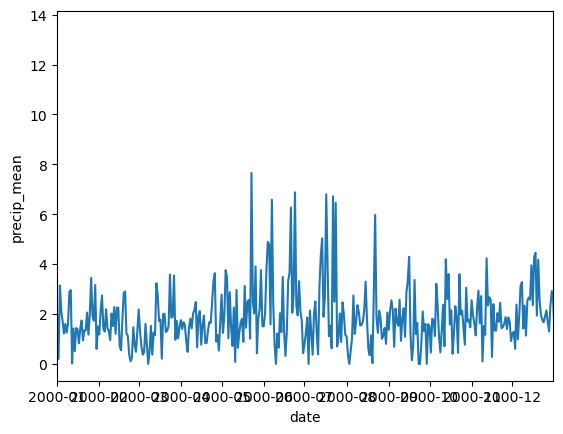

In [19]:
sns.lineplot(data=scenario_ref, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [20]:
scenario_ref = scenario_ref[scenario_ref.index.dayofweek == 0]
scenario_ref

,date,precip_mean,moisture_mean,tmean_mean,precip_std,moisture_std,tmean_std,precip_mean_prev_2d_sum,tmean_mean_prev_2d_mean,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,3.144647,82.955595,1.720142,1.221580,1.836179,0.386965,3.345521,1.583939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,2000-01-10,2.884454,85.923651,1.520624,1.465449,2.591032,0.560551,4.507865,1.754296,12.435288,1.328961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-17,2000-01-17,0.827925,82.487143,0.339189,1.303699,3.816420,0.963622,2.217111,0.637992,8.566272,0.861055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-24,2000-01-24,1.175656,85.237738,0.983248,1.436624,1.978102,0.556138,3.236242,1.770252,10.026463,1.159836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,2000-01-31,1.500832,81.736667,1.478547,0.902554,2.688088,0.442663,2.104588,1.412184,14.341519,1.721882,48.715064,1.289001,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049-11-29,2049-11-29,2.575957,86.856190,2.342736,1.426920,2.222422,0.458727,5.422135,2.791427,13.998722,3.520201,56.455866,5.063109,175.023189,9.910645,686.228570,10.098365,2086.681683,10.110937
2049-12-06,2049-12-06,1.650298,84.449167,2.317760,1.258352,2.028689,0.438305,3.315793,2.964709,9.856557,2.614447,53.865483,4.098761,168.300644,8.880205,686.790216,10.093587,2084.599450,10.109951
2049-12-13,2049-12-13,2.860345,82.059286,3.259527,1.127052,3.493577,0.706457,5.705053,3.239688,23.010352,3.009699,62.746119,3.479746,174.227428,7.918143,694.247243,10.092337,2092.549617,10.107352


(10957.0, 11322.0)

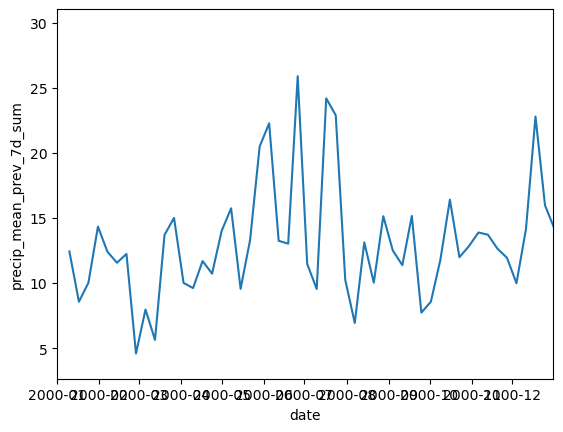

In [23]:
sns.lineplot(data=scenario_ref, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [22]:
if True:
    scenario_ref.to_csv('./data/weather_future/scenario_ref.csv', index=False)